# Exercise 3 - Geometric transformations

## Objective

In this exercise, you will implement the following geometric transformations
from scratch: horizontal flipping and resizing in `augmentations.py`. You can also 
implement random cropping as an additional but not required exercise. Your 
implementations should not only affect the images but also the associated bounding boxes. 

![](example.png)

## Details

The `hflip` function takes the image and bounding boxes as input and performs a 
horizontal flip. For example, an object initially on the left of the image will 
end up on the right.

The `resize` function takes the image, bounding boxes and target size as input. 
It scales up or down images and bounding boxes.

The `random_crop` function takes a few additional inputs. It also needs the classes, 
the crop size and the minimum area. Let's explain these parameters:
* `crop_size` is the size of the crop. It should be smaller than the dimensions of the input image.
* `min_area` is the minimum area of a bounding boxes to be considered as an object after cropping.

Because we are cropping randomly, we may only keep a tiny portion of an object, in which
case the annotations will not be useful anymore. For example, in the image below, we may not want to keep the annotation of the cat because most of the animal's body is not visible.

![](cat_cropped.png)

**Note:** You'll need to use the "Desktop" button to view the visualizations of each augmentation.

## Tips

The `hflip` transform does not affect the x coordinates of the bounding boxes.

You will use the same ratio in `resize` for the image and the bounding boxes. 

To find which bounding box belongs to the cropped area, you can use the `calculate_iou`
function.


In [31]:
import json
import copy

from PIL import Image
import numpy as np

from utils import display_results, check_results

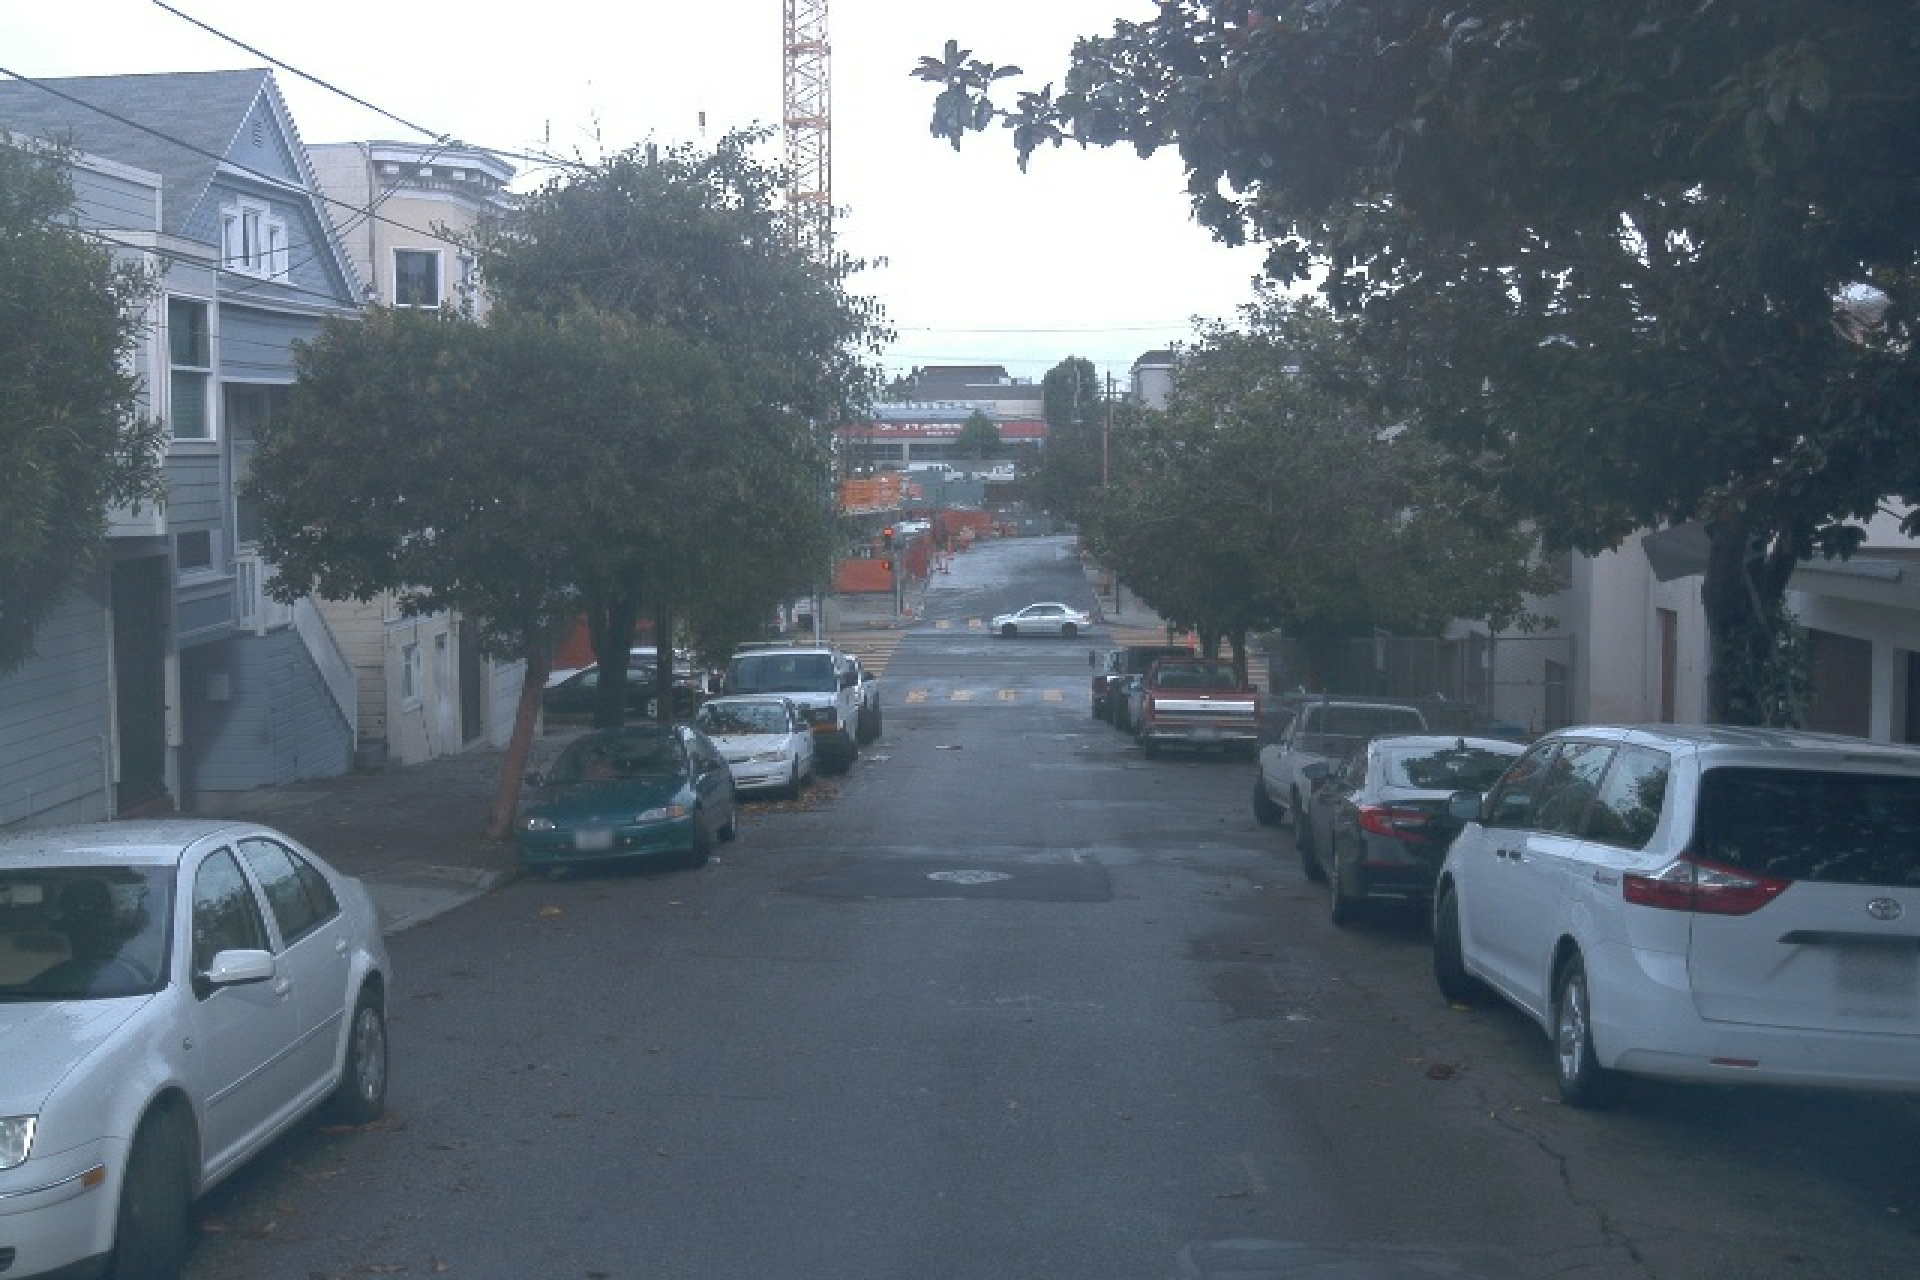

In [7]:
file_name = 'segment-12208410199966712301_4480_000_4500_000_with_camera_labels_79.png'
img = Image.open('data/images/' + file_name)
img

In [10]:
with open('data/ground_truth.json') as f:
    ground_truth = json.load(f)
    
ground_truth

[{'boxes': [[576, 545, 617, 584],
   [551, 628, 573, 651],
   [508, 437, 646, 552],
   [584, 1021, 679, 1057],
   [521, 716, 627, 756],
   [550, 711, 600, 729],
   [586, 558, 630, 617],
   [614, 76, 653, 105],
   [567, 910, 598, 927],
   [604, 1188, 826, 1244],
   [561, 542, 579, 563],
   [557, 654, 583, 684],
   [589, 1190, 655, 1240],
   [562, 559, 578, 578],
   [603, 1723, 857, 1821],
   [578, 881, 686, 923],
   [586, 942, 671, 971],
   [581, 996, 661, 1023],
   [597, 1105, 761, 1250],
   [586, 625, 646, 703],
   [558, 892, 589, 908],
   [593, 907, 684, 941],
   [577, 987, 650, 1014],
   [569, 1593, 613, 1613],
   [577, 1109, 665, 1129],
   [560, 942, 601, 963],
   [574, 1107, 665, 1149],
   [525, 321, 682, 466],
   [599, 1151, 809, 1206],
   [560, 608, 594, 642],
   [581, 512, 639, 537],
   [538, 685, 577, 706],
   [541, 543, 581, 591],
   [611, 94, 671, 123],
   [582, 1069, 681, 1110],
   [562, 900, 604, 918],
   [588, 1723, 900, 1872],
   [557, 870, 608, 883],
   [565, 956, 633, 

In [13]:
img_ground_truth = [g for g in ground_truth if g['filename'] == file_name][0]
img_ground_truth

{'boxes': [[810, 0, 1280, 393],
  [680, 1248, 854, 1486],
  [658, 1129, 759, 1261],
  [676, 1118, 736, 1148],
  [460, 907, 485, 967],
  [643, 537, 698, 726],
  [659, 541, 720, 703],
  [721, 516, 876, 734],
  [654, 842, 747, 879],
  [638, 706, 774, 860],
  [599, 989, 639, 1093],
  [596, 758, 636, 813],
  [651, 1081, 724, 1124],
  [642, 1100, 731, 1194],
  [463, 968, 485, 1030],
  [727, 1290, 929, 1536],
  [720, 1426, 1107, 1920],
  [694, 687, 800, 814]],
 'classes': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'filename': 'segment-12208410199966712301_4480_000_4500_000_with_camera_labels_79.png'}

In [14]:
boxes = img_ground_truth['boxes']
boxes

[[810, 0, 1280, 393],
 [680, 1248, 854, 1486],
 [658, 1129, 759, 1261],
 [676, 1118, 736, 1148],
 [460, 907, 485, 967],
 [643, 537, 698, 726],
 [659, 541, 720, 703],
 [721, 516, 876, 734],
 [654, 842, 747, 879],
 [638, 706, 774, 860],
 [599, 989, 639, 1093],
 [596, 758, 636, 813],
 [651, 1081, 724, 1124],
 [642, 1100, 731, 1194],
 [463, 968, 485, 1030],
 [727, 1290, 929, 1536],
 [720, 1426, 1107, 1920],
 [694, 687, 800, 814]]

In [15]:
classes = img_ground_truth['classes']
classes

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

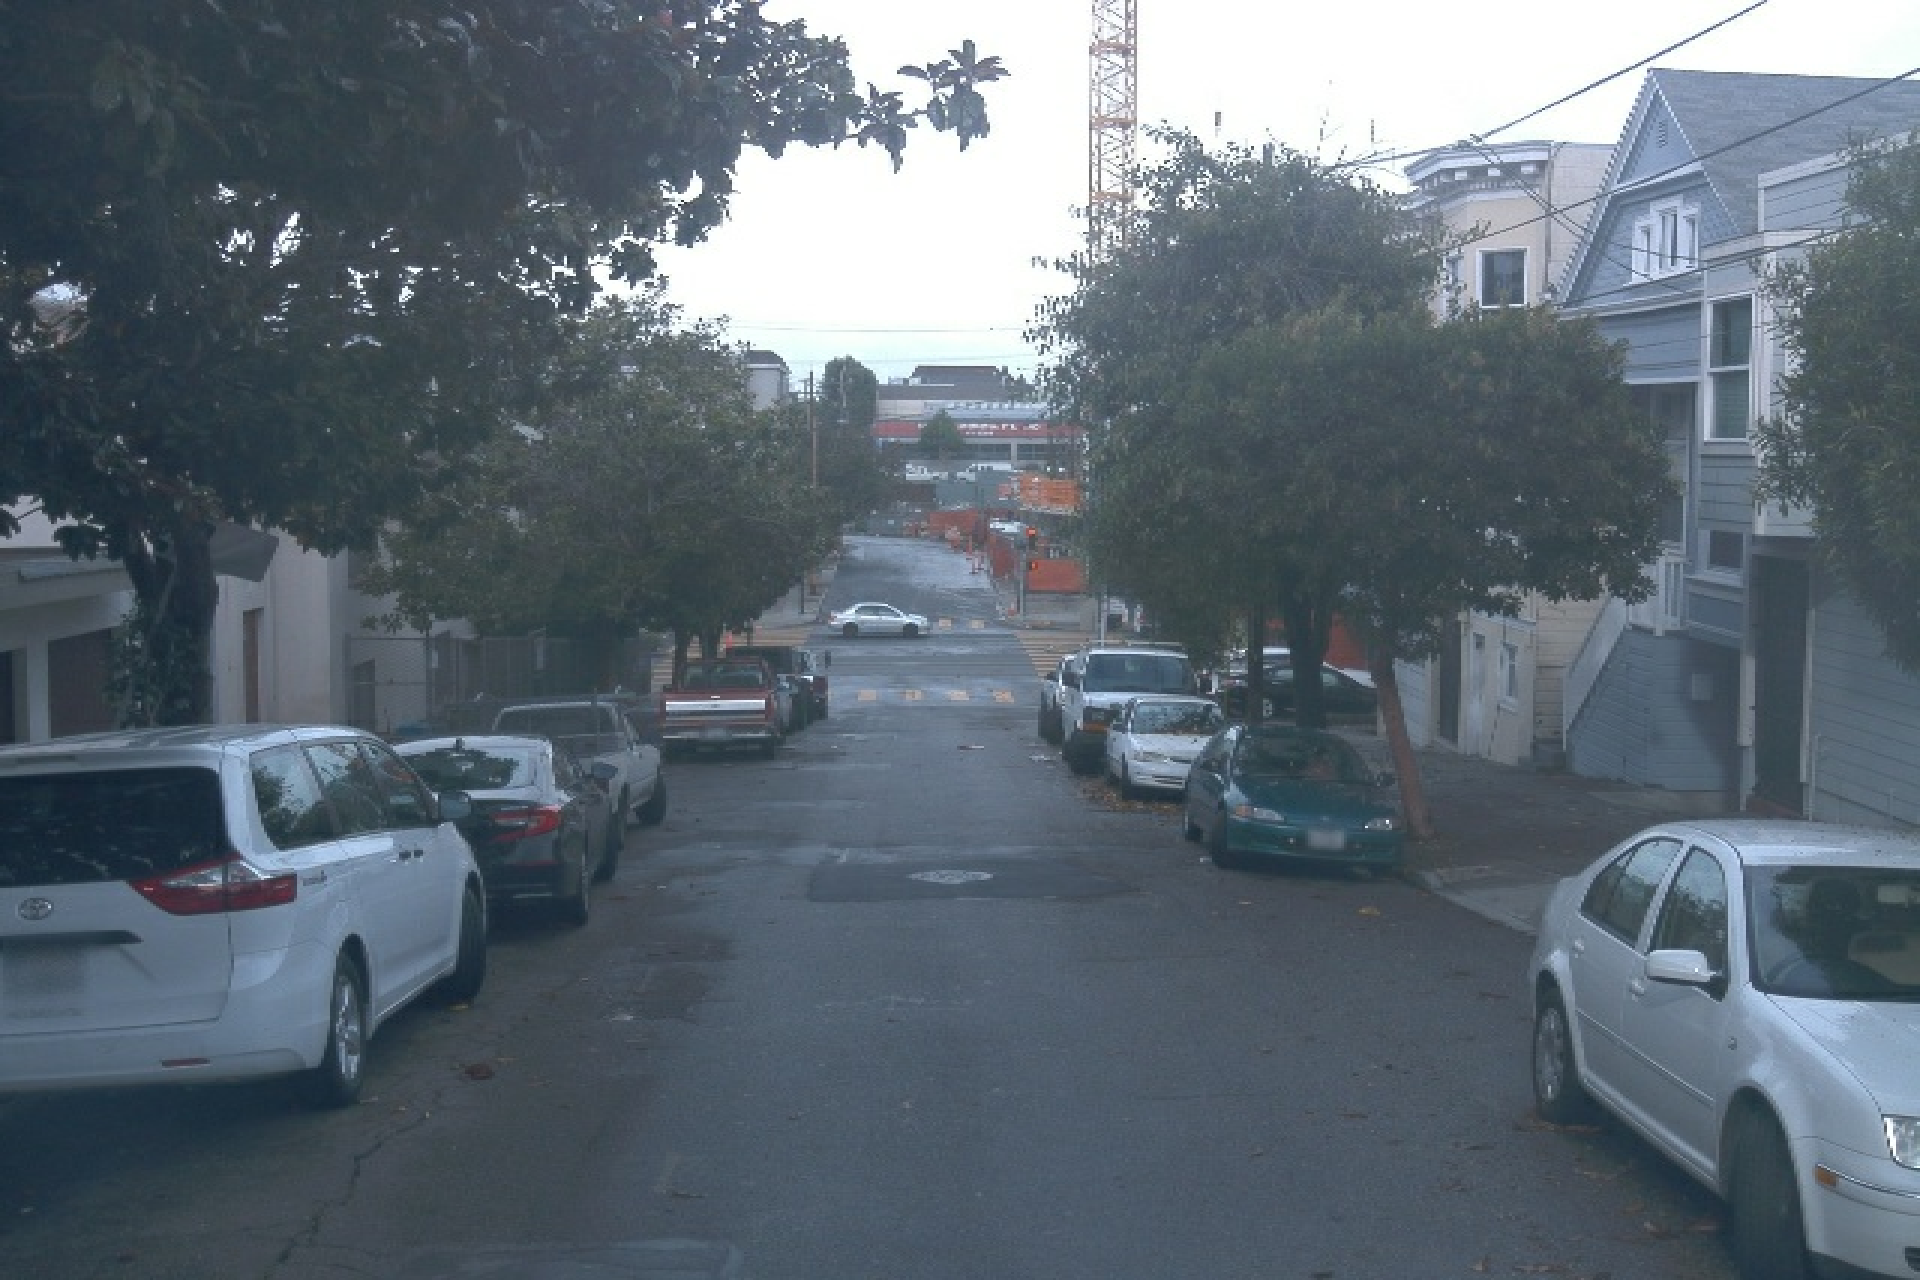

In [16]:
flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)
flipped_img

In [19]:
w, h = img.size
w, h

(1920, 1280)

In [32]:
bboxes = np.array(boxes)
bboxes

array([[ 810,    0, 1280,  393],
       [ 680, 1248,  854, 1486],
       [ 658, 1129,  759, 1261],
       [ 676, 1118,  736, 1148],
       [ 460,  907,  485,  967],
       [ 643,  537,  698,  726],
       [ 659,  541,  720,  703],
       [ 721,  516,  876,  734],
       [ 654,  842,  747,  879],
       [ 638,  706,  774,  860],
       [ 599,  989,  639, 1093],
       [ 596,  758,  636,  813],
       [ 651, 1081,  724, 1124],
       [ 642, 1100,  731, 1194],
       [ 463,  968,  485, 1030],
       [ 727, 1290,  929, 1536],
       [ 720, 1426, 1107, 1920],
       [ 694,  687,  800,  814]])

In [33]:
flipped_bboxes = copy.copy(bboxes)
flipped_bboxes

array([[ 810,    0, 1280,  393],
       [ 680, 1248,  854, 1486],
       [ 658, 1129,  759, 1261],
       [ 676, 1118,  736, 1148],
       [ 460,  907,  485,  967],
       [ 643,  537,  698,  726],
       [ 659,  541,  720,  703],
       [ 721,  516,  876,  734],
       [ 654,  842,  747,  879],
       [ 638,  706,  774,  860],
       [ 599,  989,  639, 1093],
       [ 596,  758,  636,  813],
       [ 651, 1081,  724, 1124],
       [ 642, 1100,  731, 1194],
       [ 463,  968,  485, 1030],
       [ 727, 1290,  929, 1536],
       [ 720, 1426, 1107, 1920],
       [ 694,  687,  800,  814]])

In [34]:
flipped_bboxes[:, 1] = w - bboxes[:, 3]
flipped_bboxes[:, 3] = w - bboxes[:, 1]
flipped_bboxes

array([[ 810, 1527, 1280, 1920],
       [ 680,  434,  854,  672],
       [ 658,  659,  759,  791],
       [ 676,  772,  736,  802],
       [ 460,  953,  485, 1013],
       [ 643, 1194,  698, 1383],
       [ 659, 1217,  720, 1379],
       [ 721, 1186,  876, 1404],
       [ 654, 1041,  747, 1078],
       [ 638, 1060,  774, 1214],
       [ 599,  827,  639,  931],
       [ 596, 1107,  636, 1162],
       [ 651,  796,  724,  839],
       [ 642,  726,  731,  820],
       [ 463,  890,  485,  952],
       [ 727,  384,  929,  630],
       [ 720,    0, 1107,  494],
       [ 694, 1106,  800, 1233]])

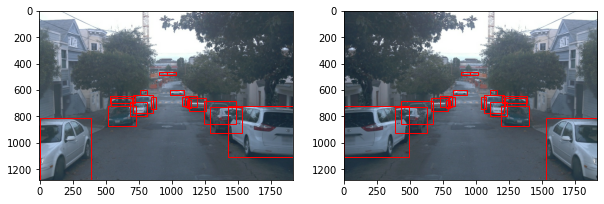

In [35]:
display_results(img, boxes, flipped_img, flipped_bboxes)

In [37]:
img.size

(1920, 1280)

In [43]:
size = [640, 640]

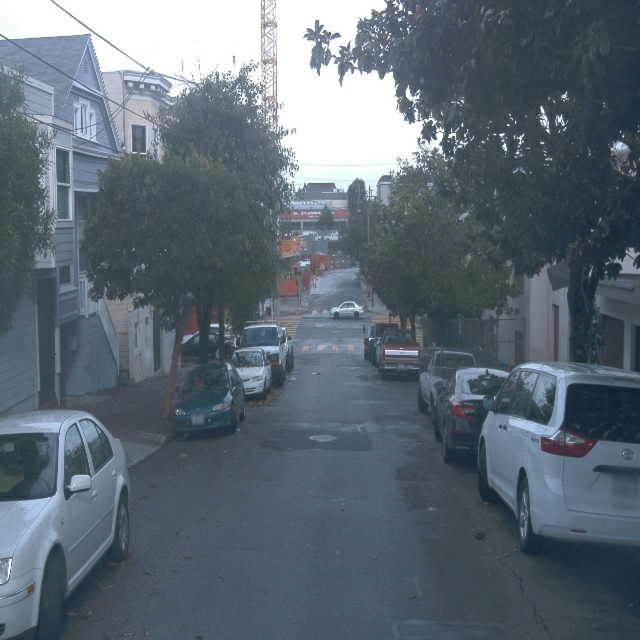

In [39]:
resized_img = img.resize(size)
resized_img

In [40]:
resized_img.size

(640, 640)

In [41]:
w, h = img.size
w, h

(1920, 1280)

In [57]:
1920*1280

2457600

In [58]:
640*640

409600

In [44]:
w_ratio = size[0] / w
h_ratio = size[1] / h
w_ratio, h_ratio

(0.3333333333333333, 0.5)

In [45]:
boxes

[[810, 0, 1280, 393],
 [680, 1248, 854, 1486],
 [658, 1129, 759, 1261],
 [676, 1118, 736, 1148],
 [460, 907, 485, 967],
 [643, 537, 698, 726],
 [659, 541, 720, 703],
 [721, 516, 876, 734],
 [654, 842, 747, 879],
 [638, 706, 774, 860],
 [599, 989, 639, 1093],
 [596, 758, 636, 813],
 [651, 1081, 724, 1124],
 [642, 1100, 731, 1194],
 [463, 968, 485, 1030],
 [727, 1290, 929, 1536],
 [720, 1426, 1107, 1920],
 [694, 687, 800, 814]]

In [49]:
bboxes = np.array(boxes)
bboxes

array([[ 810,    0, 1280,  393],
       [ 680, 1248,  854, 1486],
       [ 658, 1129,  759, 1261],
       [ 676, 1118,  736, 1148],
       [ 460,  907,  485,  967],
       [ 643,  537,  698,  726],
       [ 659,  541,  720,  703],
       [ 721,  516,  876,  734],
       [ 654,  842,  747,  879],
       [ 638,  706,  774,  860],
       [ 599,  989,  639, 1093],
       [ 596,  758,  636,  813],
       [ 651, 1081,  724, 1124],
       [ 642, 1100,  731, 1194],
       [ 463,  968,  485, 1030],
       [ 727, 1290,  929, 1536],
       [ 720, 1426, 1107, 1920],
       [ 694,  687,  800,  814]])

In [52]:
bboxes[:, [0, 2]] = bboxes[:, [0, 2]] * h_ratio
bboxes

array([[ 405,    0,  640,  393],
       [ 340, 1248,  427, 1486],
       [ 329, 1129,  379, 1261],
       [ 338, 1118,  368, 1148],
       [ 230,  907,  242,  967],
       [ 321,  537,  349,  726],
       [ 329,  541,  360,  703],
       [ 360,  516,  438,  734],
       [ 327,  842,  373,  879],
       [ 319,  706,  387,  860],
       [ 299,  989,  319, 1093],
       [ 298,  758,  318,  813],
       [ 325, 1081,  362, 1124],
       [ 321, 1100,  365, 1194],
       [ 231,  968,  242, 1030],
       [ 363, 1290,  464, 1536],
       [ 360, 1426,  553, 1920],
       [ 347,  687,  400,  814]])

In [53]:
bboxes[:, [1, 3]] = bboxes[:, [1, 3]] * w_ratio
bboxes

array([[405,   0, 640, 131],
       [340, 416, 427, 495],
       [329, 376, 379, 420],
       [338, 372, 368, 382],
       [230, 302, 242, 322],
       [321, 179, 349, 242],
       [329, 180, 360, 234],
       [360, 172, 438, 244],
       [327, 280, 373, 293],
       [319, 235, 387, 286],
       [299, 329, 319, 364],
       [298, 252, 318, 271],
       [325, 360, 362, 374],
       [321, 366, 365, 398],
       [231, 322, 242, 343],
       [363, 430, 464, 512],
       [360, 475, 553, 640],
       [347, 229, 400, 271]])

Start


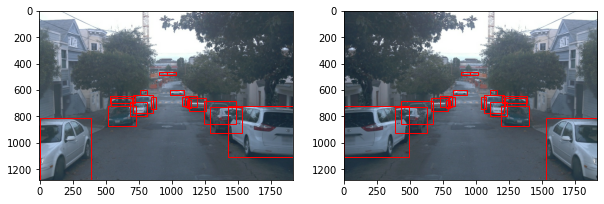

Horizontal flip is working


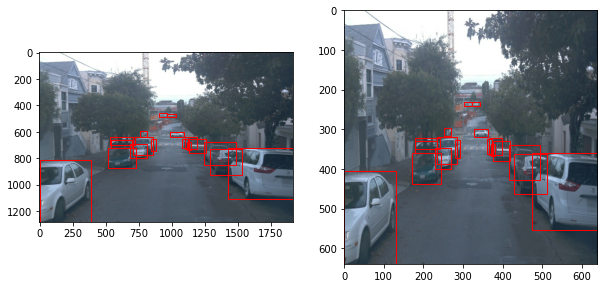

Resizing is working


In [56]:
import json
import copy

from PIL import Image
import numpy as np

from utils import display_results, check_results


def calculate_iou(gt_bbox, pred_bbox):
    """
    calculate iou 
    args:
    - gt_bbox [array]: 1x4 single gt bbox
    - pred_bbox [array]: 1x4 single pred bbox
    returns:
    - iou [float]: iou between 2 bboxes
    """
    xmin = np.max([gt_bbox[0], pred_bbox[0]])
    ymin = np.max([gt_bbox[1], pred_bbox[1]])
    xmax = np.min([gt_bbox[2], pred_bbox[2]])
    ymax = np.min([gt_bbox[3], pred_bbox[3]])
    
    intersection = max(0, xmax - xmin) * max(0, ymax - ymin)
    gt_area = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])
    pred_area = (pred_bbox[2] - pred_bbox[0]) * (pred_bbox[3] - pred_bbox[1])
    
    union = gt_area + pred_area - intersection
    return intersection / union, [xmin, ymin, xmax, ymax]


def hflip(img, bboxes):
    """
    horizontal flip of an image and annotations
    args:
    - img [PIL.Image]: original image
    - bboxes [list[list]]: list of bounding boxes
    return:
    - flipped_img [PIL.Image]: horizontally flipped image
    - flipped_bboxes [list[list]]: horizontally flipped bboxes
    """
    # IMPLEMENT THIS FUNCTION
    flipped_img = img.transpose(Image.FLIP_LEFT_RIGHT)

    w, h = img.size
    
    bboxes = np.array(boxes)
    flipped_bboxes = copy.copy(bboxes)
    flipped_bboxes[:, 1] = w - bboxes[:, 3]
    flipped_bboxes[:, 3] = w - bboxes[:, 1]

    return flipped_img, flipped_bboxes


def resize(img, boxes, size):
    """
    horizontal flip of an image and annotations
    args:
    - img [PIL.Image]: original image
    - boxes [list[list]]: list of bounding boxes
    - size [array]: 1x2 array [width, height]
    returns:
    - resized_img [PIL.Image]: resized image
    - resized_boxes [list[list]]: resized bboxes
    """
    # IMPLEMENT THIS FUNCTION
    resized_img = img.resize(size)
    
    w, h = img.size
    w_ratio = size[0] / w
    h_ratio = size[1] / h
    resized_boxes = np.array(boxes)
    resized_boxes[:, [0, 2]] = resized_boxes[:, [0, 2]] * h_ratio
    resized_boxes[:, [1, 3]] = resized_boxes[:, [1, 3]] * w_ratio
    
    return resized_img, resized_boxes


def random_crop(img, boxes, crop_size, min_area=100):
    """
    random cropping of an image and annotations
    args:
    - img [PIL.Image]: original image
    - boxes [list[list]]: list of bounding boxes
    - crop_size [array]: 1x2 array [width, height]
    - min_area [int]: min area of a bbox to be kept in the crop
    returns:
    - cropped_img [PIL.Image]: resized image
    - cropped_boxes [list[list]]: resized bboxes
    """
    # IMPLEMENT THIS FUNCTION
    return cropped_image, cropped_boxes


if __name__ == '__main__':
    print('Start')
    
    np.random.seed(48)
    
    file_name = 'segment-12208410199966712301_4480_000_4500_000_with_camera_labels_79.png'
    img = Image.open('data/images/' + file_name)
    
    with open('data/ground_truth.json') as f:
        ground_truth = json.load(f)
        
    img_ground_truth = [g for g in ground_truth if g['filename'] == file_name][0]
    boxes = img_ground_truth['boxes']
    classes = img_ground_truth['classes']

   # check horizontal flip
    flipped_img, flipped_bboxes = hflip(img, boxes)
    display_results(img, boxes, flipped_img, flipped_bboxes)
    check_results(flipped_img, flipped_bboxes, aug_type='hflip')    

    # check resize
    resized_image, resized_boxes = resize(img, boxes, size=[640, 640])
    display_results(img, boxes, resized_image, resized_boxes)
    check_results(resized_image, resized_boxes, aug_type='resize')

    # check random crop
#     cropped_image, cropped_boxes, cropped_classes = random_crop(img, boxes, gt_classes, [512, 512], min_area=100)
#     display_results(img, boxes, cropped_image, cropped_boxes)
#     check_results(cropped_image, cropped_boxes, aug_type='random_crop', classes=cropped_classes)    
    